# Classify complaints per product based on the consumer narrative

## Multi-classification example with pipeline for algorithm selection using grid search

Nuno António - Rev. 1.00 - January, 2020

### Dataset description
Complaints about financial products and services presented to the Consumer Financial Protection Bureau (USA government agency responsible for consumer protection in the financial sector).

The dataset is composed of the following variables:

- **data_received**: date the complaint was received.
- **product**: type of financial product.
- **sub_produtc**: type of sub-product.
- **issue**: summary of the complaint.
- **sub_issue**: sub-issue of the complaint.
- **consumer_complaint_narrative**: description of the complaint as made by the consumer.
- **company_public_response**: response given by the company.
- **company**: company which complaint was about.
- **state**: location of the consumer (state).
- **zip_code**: location of the consumer(zip code).
- **tags**: classification tags given by agent.
- **consumer_consent_provided**: consumer consenented information to be used?
- **submitted_via**: how was the complaint submitted.
- **date_sent_to_company**: date when complaint was sent to the company.
- **company_response_to_consumer**: type of response given by the company to the consumer.
- **timely_response**: was response given in a timely fashion?
- **consumer_disputed**: consumer disputed the company's response?
- **complaint_id**: ID of the complaint.


More information on the dataset available at https://data.world/chandrasekar/consumer-complaints


The objective is to use the what the consumers complained about (in textual format) as features to predict which type of product were they making a complaint about.

### Initial setup and modules/packages loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Data understanding

In [3]:
# Load data 
ds = pd.read_csv('Consumer_Complaints.tsv',sep='\t')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 5000 non-null   object
 1   product                       5000 non-null   object
 2   sub_product                   4173 non-null   object
 3   issue                         5000 non-null   object
 4   sub_issue                     3300 non-null   object
 5   consumer_complaint_narrative  828 non-null    object
 6   company_public_response       1541 non-null   object
 7   company                       5000 non-null   object
 8   state                         4945 non-null   object
 9   zip_code                      4934 non-null   object
 10  tags                          667 non-null    object
 11  consumer_consent_provided     1822 non-null   object
 12  submitted_via                 5000 non-null   object
 13  date_sent_to_compa

In [4]:
# Display top 10 rows
ds.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2017-03-21,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77075,Older American,NaN,Phone,2017-03-21,Closed with non-monetary relief,True,No,2397100
1,2017-04-19,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not disclosed as an attempt to collect,NaN,NaN,"Security Credit Services, LLC",IL,60643,NaN,NaN,Web,2017-04-20,Closed with explanation,True,No,2441777
2,2017-04-19,Credit card,NaN,Other,NaN,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,62025,NaN,NaN,Referral,2017-04-20,Closed with explanation,True,No,2441830
3,2017-04-14,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,2017-04-14,Closed with explanation,True,No,2436165
4,2017-04-19,Credit card,NaN,Credit determination,NaN,NaN,Company has responded to the consumer and the ...,U.S. BANCORP,LA,70571,NaN,NaN,Postal mail,2017-04-21,Closed with explanation,True,No,2441726
5,2017-04-18,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,"Rubin & Rothman, LLC",NY,14063,NaN,NaN,Referral,2017-04-19,In progress,True,No,2440364
6,2017-04-18,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,"QUICKEN LOANS, INC.",FL,33772,Older American,NaN,Referral,2017-04-19,In progress,True,No,2441409
7,2016-05-18,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",NJ,08618,NaN,NaN,Referral,2016-05-23,Closed with explanation,True,No,1931957
8,2017-03-17,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,WI,54005,NaN,NaN,Referral,2017-03-20,Closed with explanation,True,No,2393048
9,2016-11-18,Mortgage,Conventional fixed mortgage,Settlement process and costs,NaN,Started the refinance of home mortgage process...,NaN,AMERICAN NEIGHBORHOOD MORTGAGE,NJ,088XX,NaN,Consent provided,Web,2016-11-21,Closed with monetary relief,False,No,2216206


In [5]:
# Summary statistics for all variables
summary=ds.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_received,5000,418,2017-04-26,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,5000,17,Debt collection,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_product,4173,70,Credit reporting,876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issue,5000,125,Incorrect information on your report,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_issue,3300,156,Information belongs to someone else,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consumer_complaint_narrative,828,824,On my credit report the creditors that are rep...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_public_response,1541,9,Company has responded to the consumer and the ...,1204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company,5000,676,EXPERIAN DELAWARE GP,493,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,4945,56,CA,618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_code,4934,2437,300XX,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Show products (target)
ds['product'].value_counts()

Debt collection                                                                 1264
Credit reporting, credit repair services, or other personal consumer reports     896
Mortgage                                                                         741
Credit reporting                                                                 466
Student loan                                                                     381
Credit card                                                                      331
Bank account or service                                                          300
Consumer Loan                                                                    179
Credit card or prepaid card                                                      153
Checking or savings account                                                       90
Vehicle loan or lease                                                             60
Payday loan                                                      

### Data preparation

In [7]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [8]:
# Remove rows without narrative
X = X[pd.notnull(X['consumer_complaint_narrative'])]

In [11]:
# For speed pruposes, let's only use a 5000 sample
X = X.sample(n=5000, replace=False, random_state=123)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [42]:
# Use only "product" and "consumer_complaint_narrative" columns
cols = ['product', 'consumer_complaint_narrative']
X = X[cols]

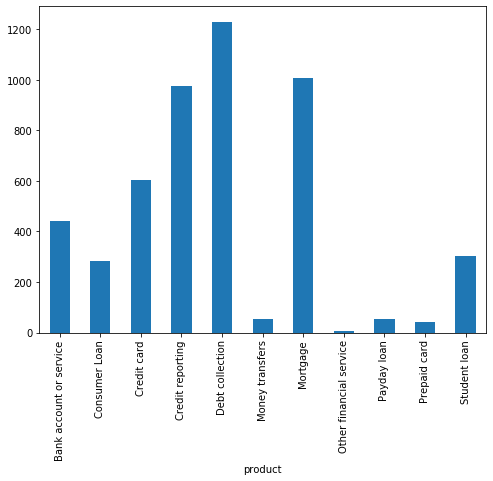

In [43]:
# Plot complaints by product
fig = plt.figure(figsize=(8,6))
X.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [44]:
# Create a column with the product ID (from the category)
X['product_id'] = pd.factorize(X['product'])[0]

In [45]:
# Create features from the consumer narrative via TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_features = tfidf.fit_transform(X.consumer_complaint_narrative).toarray()

In [46]:
# Create the Target
y = X['product_id']

### Modeling

In [47]:
# Do cross-validation with multiple algorithms and randomized search to select which to use
np.random.seed(123) 
algorithms = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10)},
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [100, 200, 300],
                 "classifier__max_depth":[3,4],
                 "classifier__min_samples_leaf":[2,5,10]},
                {"classifier": [LinearSVC()]},
                {"classifier": [MultinomialNB()]}
              ]
pipe = Pipeline([("classifier", RandomForestClassifier())])
gridSearch = GridSearchCV(pipe, algorithms, cv=5, verbose=1, n_jobs=-1)
best_model = gridSearch.fit(X_features, y)
print("The mean accuracy of the model is:",best_model.score(X_features, y))
print("The best parameters for the model are:",best_model.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.9min finished
The mean accuracy of the model is: 0.9972
The best parameters for the model are: {'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)}


In [48]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.25, stratify=y, random_state=123)

In [49]:
# Train with the best algorithm and best parameters
classModel = best_model.best_estimator_[0]
classModel.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Evaluation

In [50]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train) 
y_pred_test = classModel.predict(X_test) 

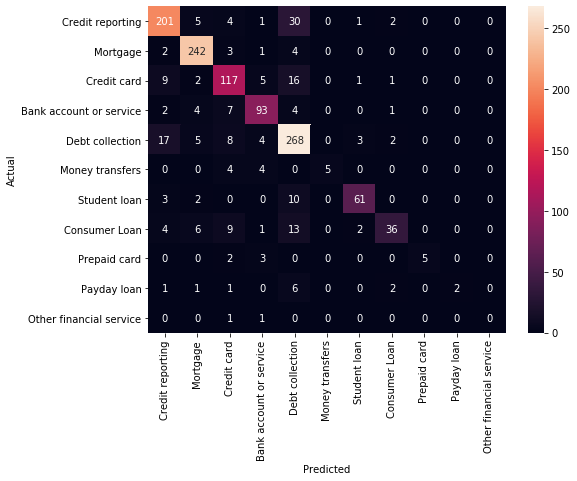

In [51]:
# Plot consusion matrix of the test set results
product_id_df = X[['product', 'product_id']].drop_duplicates().sort_values('product_id')
conf_mat = confusion_matrix(y_test, y_pred_test)
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
    xticklabels=product_id_df['product'].values, yticklabels=product_id_df['product'].values)
bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
ax.set_ylim(bottom + 0.5, top - 0.5) #
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [52]:
# Show metrics results
print(metrics.classification_report(y_test, y_pred_test, target_names=X['product'].unique()))

precision    recall  f1-score   support

       Credit reporting       0.84      0.82      0.83       244
               Mortgage       0.91      0.96      0.93       252
            Credit card       0.75      0.77      0.76       151
Bank account or service       0.82      0.84      0.83       111
        Debt collection       0.76      0.87      0.81       307
        Money transfers       1.00      0.38      0.56        13
           Student loan       0.90      0.80      0.85        76
          Consumer Loan       0.82      0.51      0.63        71
           Prepaid card       1.00      0.50      0.67        10
            Payday loan       1.00      0.15      0.27        13
Other financial service       0.00      0.00      0.00         2

               accuracy                           0.82      1250
              macro avg       0.80      0.60      0.65      1250
           weighted avg       0.83      0.82      0.82      1250

/Library/Frameworks/Python.framework/Versions/3